In [1]:
%load_ext autoreload
%autoreload 2

In [48]:
import os, sys
import numpy as np 
# import pandas as pd 
import matplotlib.pyplot as plt
# import geopandas as gpd
import sklearn, sklearn.cross_decomposition
from sklearn.cross_decomposition import CCA
from tqdm import tqdm
sys.path.append('../src/')
sys.path.append('../content/')
import data_utils as du
import loadpaths
path_dict_pecl = loadpaths.loadpaths()
import analysis_utils as au


In [76]:

# Then collect from all patches the alpha and dyn data
patches = 10
hypotheses = []
features = []
sentinel = []
for p in range(patches):
    (data_sent, data_alpha, data_dyn, data_worldclim, data_dsm) = du.load_all_modalities_from_name(name=f'pecl-fig-{p}', path_folder='../content/sample_data', verbose=1)
    # Land coverage serves as hypotheses
    hypotheses.append(data_dyn.data)
    # This can definitely be cleaner but I use nan for undefined values
    f_dat = data_alpha.data
    f_dat[~np.isfinite(f_dat)] = np.nan
    features.append(f_dat)    
    sentinel.append(data_sent.data)

# # Z-score across patches for each feature and each hypothesis
# feat_m = np.stack([np.nanmean(f) for f in np.stack(features, axis=-1)])
# feat_std = np.stack([np.nanstd(f) for f in np.stack(features, axis=-1)])
# features = [(f - feat_m[:,None,None])/feat_std[:,None,None] for f in features]
# hyp_m = np.stack([np.nanmean(h) for h in np.stack(hypotheses, axis=-1)])
# hyp_std = np.stack([np.nanstd(h) for h in np.stack(hypotheses, axis=-1)])
# hypotheses = [(h - hyp_m[:,None,None])/hyp_std[:,None,None] for h in hypotheses]


Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
DSM: (1, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Sentinel-2: (4, 128, 128) <class 'xarray.core.dataarray.DataArray'>
AlphaEarth: (64, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Dynamic World: (9, 128, 128) <class 'xarray.core.dataarray.DataArray'>
WorldClimBio: <class 'dict'> dict_keys(['bio01', 'bio02', 'bio03', 'bio04', 'bio05', 'bio06', 'bio07', 'bio08', 'bio09', 'bio10', 'bio11', 'bio12', 'bio13', 'bio14', 'bio15', 'bio16', 'bio17', 'bio18', 'bio19', 'coords', 'name'])
DSM: (1, 128, 128) <class 'xarray.core.dataarray.DataArray'>
Se

In [ ]:
# import pysal
# from skimage.io import imread
from libpysal.weights import lat2W
# import numpy as np
# import pandas as pd
from esda.moran import Moran
# from skimage.color import rgb2gray
from splot.esda import moran_scatterplot

def Morans_I(data, plot=True):
    """transforming RGB data to grayscale.
    
    Source: https://github.com/simon-donike/Morans_I/blob/master/Morans_I.ipynb"""
    assert len(data.shape) == 2
    col, row = data.shape
    WeightMatrix = lat2W(row, col)
    WeightMatrix = lat2W(data.shape[0], data.shape[1])
    MoranM = Moran(data, WeightMatrix)
    if plot:
        fig, ax = moran_scatterplot(MoranM, aspect_equal=True)

        print("Raster Dimensions:\t" + str(data.shape))
        print("Moran's I Value:\t" +str(round(MoranM.I,4)))
    # return MoranM.I

(64, 128, 128)

In [64]:
# Morans_I(features[0][0, ...])
vals_moran = []
for i, f in tqdm(enumerate(features[4])):
    data = f
    col, row = data.shape
    WeightMatrix = lat2W(row, col)
    WeightMatrix = lat2W(data.shape[0], data.shape[1])
    moran = Moran(data, WeightMatrix).I
    if moran == np.nan:
        break
    vals_moran.append(moran)


64it [00:19,  3.23it/s]


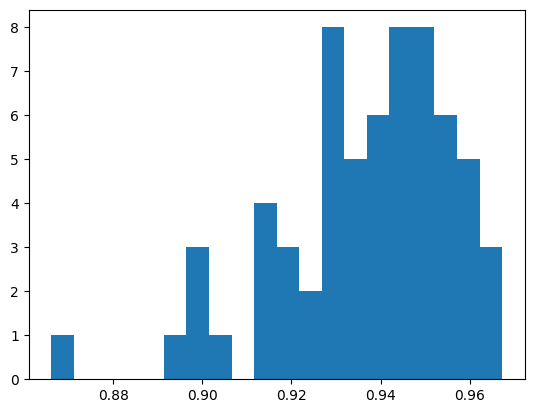

In [65]:
plt.hist(np.array(vals_moran), bins=20);

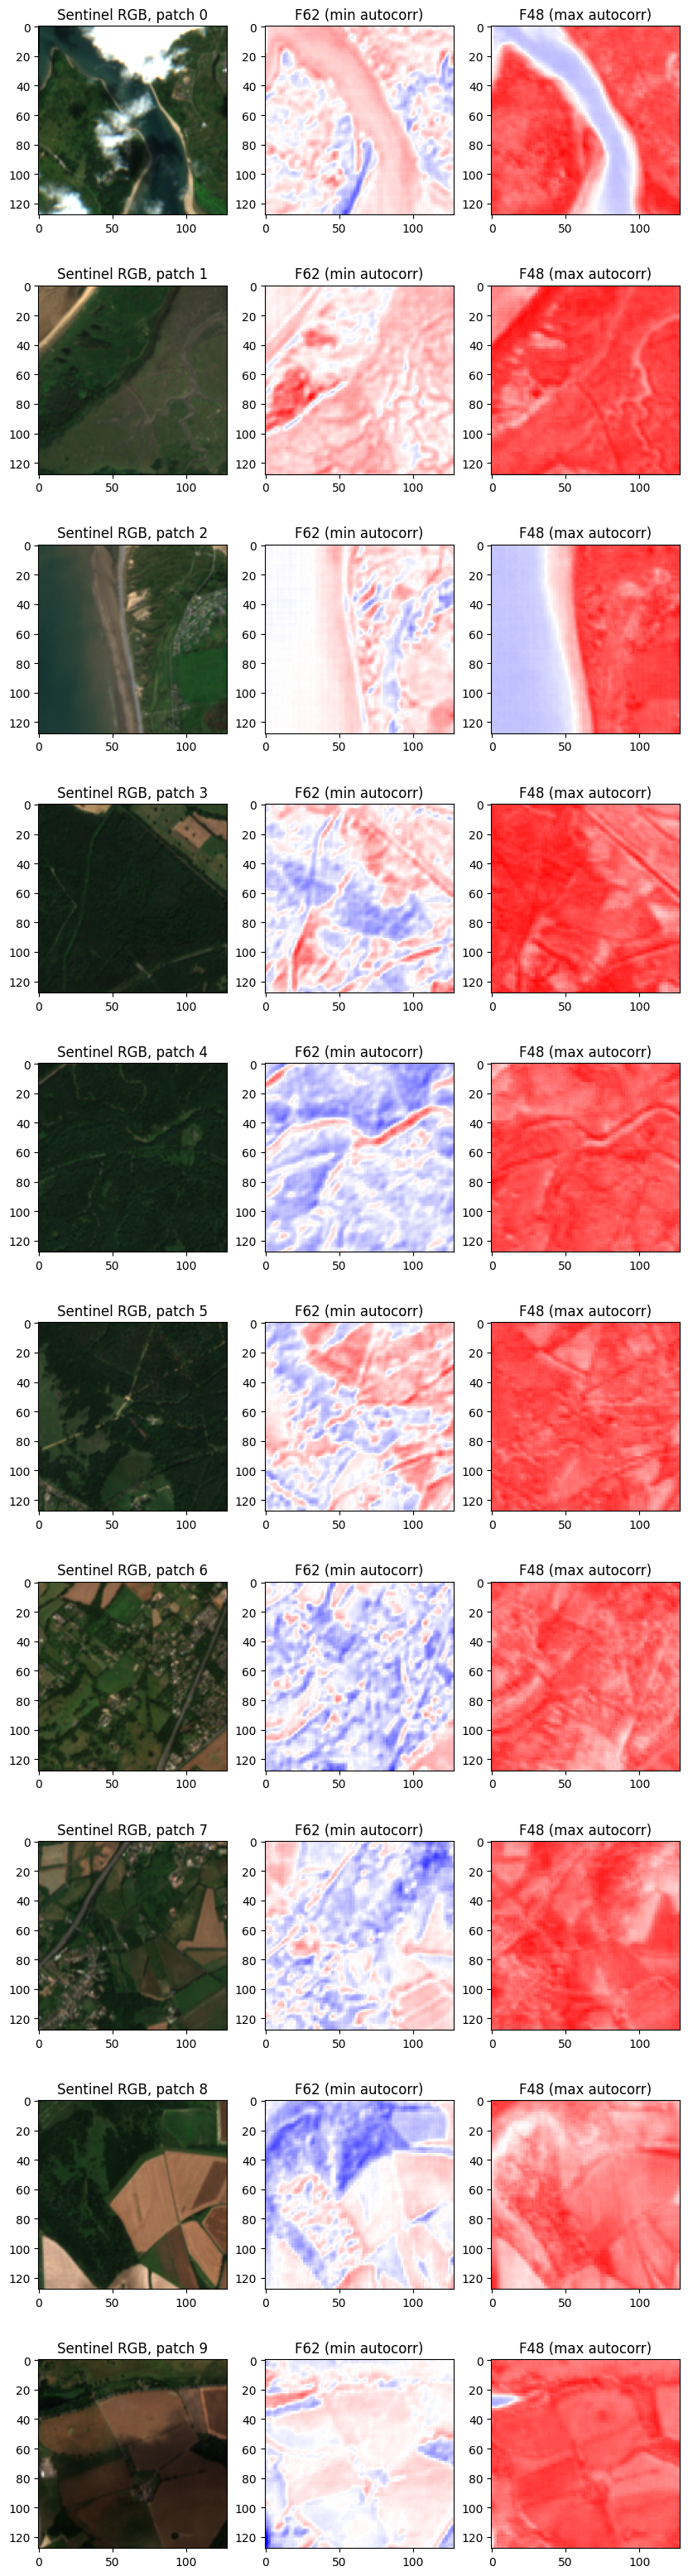

In [114]:
fig, ax = plt.subplots(10,3, figsize=(10,40))
ind_min, ind_max = 62, 48
lim_minf = np.nanmax(np.abs(np.stack(features, axis=-1)[ind_min, ...]))
lim_maxf = np.nanmax(np.abs(np.stack(features, axis=-1)[ind_max, ...]))
for i_patch in range(10):

    # ind_min, val_min = np.argsort(vals_moran)[3], np.min(vals_moran)
    # ind_max, val_max = np.argmax(vals_moran), np.max(vals_moran)
    # ind_min, ind_max = 62, 48
    # val_min, val_max = vals_moran[ind_min], vals_moran[ind_max]

    ax[i_patch, 0].imshow(np.clip(np.swapaxes(np.swapaxes(sentinel[i_patch][:3], 0, 2), 0, 1), 0, 3000) / 3000)
    ax[i_patch, 0].set_title(f'Sentinel RGB, patch {i_patch}')

    lim = np.abs(features[i_patch][ind_min]).max()
    ax[i_patch, 1].imshow(features[i_patch][ind_min], vmin=-lim_minf, vmax=lim_minf, cmap='bwr')
    # ax[i_patch, 1].set_title(f'F{ind_min} (min autocorr):\n Moran I = {val_min:.2f}')
    ax[i_patch, 1].set_title(f'F{ind_min} (min autocorr)')

    lim = np.abs(features[i_patch][ind_max]).max()
    ax[i_patch, 2].imshow(features[i_patch][ind_max], vmin=-lim_maxf, vmax=lim_maxf, cmap='bwr')
    # ax[i_patch, 2].set_title(f'F{ind_max} (max autocorr):\n Moran I = {val_max:.2f}')
    ax[i_patch, 2].set_title(f'F{ind_max} (max autocorr)')


In [113]:
features[0]

array([[[            nan, -1.30165321e-01, -1.24567474e-01, ...,
         -1.92910419e-01, -1.99861592e-01, -1.99861592e-01],
        [            nan, -1.35886198e-01, -1.24567474e-01, ...,
         -1.99861592e-01, -2.06935794e-01, -2.06935794e-01],
        [            nan, -1.35886198e-01, -1.30165321e-01, ...,
         -2.06935794e-01, -2.06935794e-01, -2.14133026e-01],
        ...,
        [-1.92910419e-01, -2.06935794e-01, -1.86082276e-01, ...,
         -1.86082276e-01, -1.92910419e-01, -1.92910419e-01],
        [-1.99861592e-01, -2.06935794e-01, -1.86082276e-01, ...,
         -1.79377163e-01, -1.86082276e-01, -1.86082276e-01],
        [-2.06935794e-01, -2.06935794e-01, -1.79377163e-01, ...,
         -1.92910419e-01, -1.99861592e-01, -1.92910419e-01]],

       [[            nan, -1.41730104e-01, -1.30165321e-01, ...,
         -1.99861592e-01, -1.86082276e-01, -1.72795079e-01],
        [            nan, -1.41730104e-01, -1.30165321e-01, ...,
         -1.99861592e-01, -1.86082276e

## Corr & dim

(64, 163822)


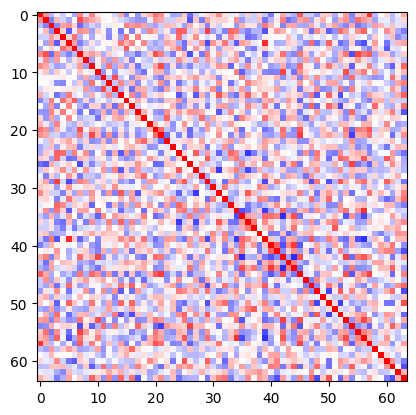

In [91]:
features_all = np.stack(features, axis=0)
features_all = au.ravel_features(features_all)
features_all = features_all[:, np.isnan(features_all).sum(0) == 0]
print(features_all.shape)

corr_mat = np.corrcoef(features_all[:, :])
plt.imshow(corr_mat, vmin=-1, vmax=1, cmap='bwr')

Text(0, 0.5, 'Distance')

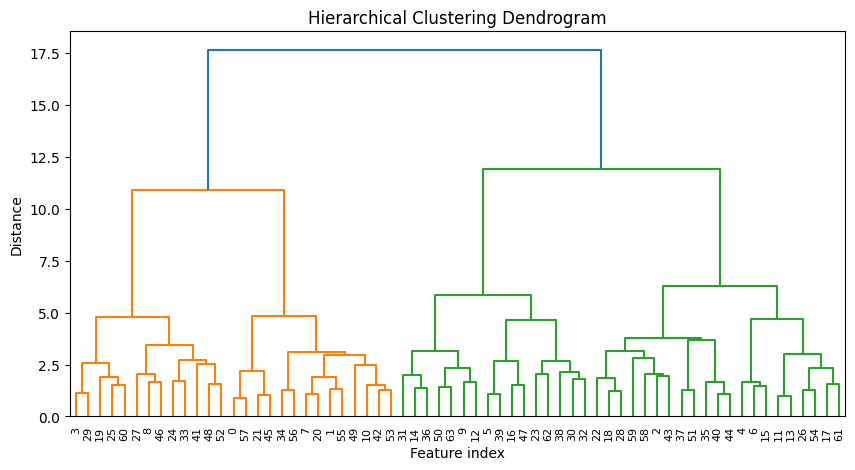

In [115]:
## Hierarchical clustering of features
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
Z = linkage(corr_mat, 'ward')
plt.figure(figsize=(10, 5))
dendro = dendrogram(Z, leaf_rotation=90., leaf_font_size=8.)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature index')
plt.ylabel('Distance')


Text(0.5, 1.0, 'Correlation matrix of features')

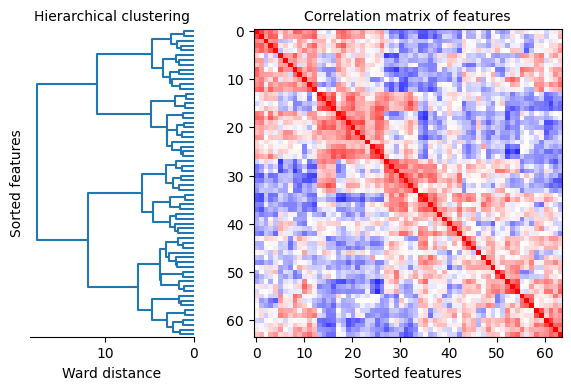

In [140]:
## Hierarchical clustering of features
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
Z = linkage(corr_mat, 'ward')

fig, ax = plt.subplots(1, 2, figsize=(7, 4), gridspec_kw={'width_ratios': [1, 2], 'hspace': 0.0})

dendro = dendrogram(Z, orientation='left', leaf_rotation=0., 
                    leaf_font_size=8., ax=ax[0], color_threshold=0,
                    leaf_label_func=lambda x: str() if x % 10 == 0 else '')
ax[0].set_title('Hierarchical clustering', fontsize=10)
ax[0].set_xlabel('Ward distance')
ax[0].set_ylabel('Sorted features')
ax[0].invert_yaxis()
for sp in ['left', 'top', 'right']:
    ax[0].spines[sp].set_visible(False)


corr_mat_sorted = corr_mat[dendro['leaves'], :][:, dendro['leaves']]
ax[1].imshow(corr_mat_sorted, vmin=-1, vmax=1, cmap='bwr')
ax[1].set_xlabel('Sorted features')
ax[1].set_title('Correlation matrix of features', fontsize=10)

In [161]:
np.array(dendro['leaves'])

array([ 3, 29, 19, 25, 60, 27,  8, 46, 24, 33, 41, 48, 52,  0, 57, 21, 45,
       34, 56,  7, 20,  1, 55, 49, 10, 42, 53, 31, 14, 36, 50, 63,  9, 12,
        5, 39, 16, 47, 23, 62, 38, 30, 32, 22, 18, 28, 59, 58,  2, 43, 37,
       51, 35, 40, 44,  4,  6, 15, 11, 13, 26, 54, 17, 61])

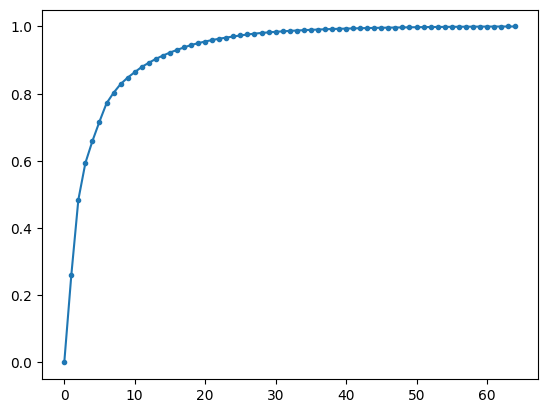

In [149]:
pca = sklearn.decomposition.PCA(n_components=64)
pca.fit(features_all.T)
plt.plot(np.concatenate([[0], np.cumsum(pca.explained_variance_ratio_)]), '.-')
pr_evs = np.sum()

In [153]:
1 / np.sum((pca.explained_variance_ / np.sum(pca.explained_variance_)))

1.0

In [159]:
sum_squares = np.sum(np.power(pca.explained_variance_, 2))
square_sum = np.sum(pca.explained_variance_) ** 2
square_sum / sum_squares

6.952231833830072

In [167]:
features[1].shape

(64, 128, 128)

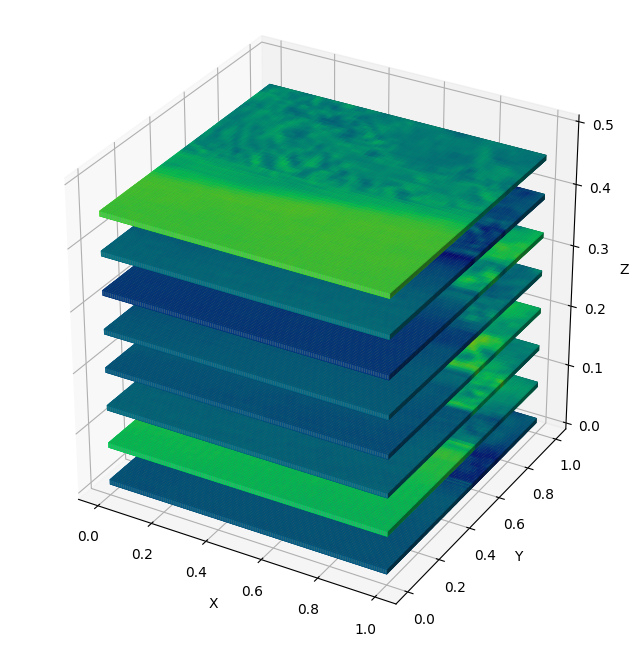

In [170]:
## Adapted from http://matplotlib.org/stable/gallery/mplot3d/voxels_rgb.html

mat_vals = features[2]  # shape 
mat_vals = np.swapaxes(mat_vals, 0, 2)  # shape 
mat_vals = np.swapaxes(mat_vals, 0, 1)  # shape
width, depth, height = mat_vals.shape

# Create a 3D grid
x, y, z = np.indices((width+1, depth+1, height+1)) / max(width, depth, height)

# Create a block: True where the voxel exists
cube = np.ones((width, depth, height), dtype=bool)

# Add gaps between height layers
for layer in range(height):
    if layer % 8 != 1:
        cube[:, :, layer] = False  # create gaps

# Map mat_vals to colors
# We'll use a colormap to convert values to RGB
cmap = plt.cm.viridis  # choose any matplotlib colormap
norm_vals = (mat_vals - mat_vals.min()) / (mat_vals.max() - mat_vals.min())  # normalize to [0,1]

colors = np.zeros(cube.shape + (4,))  # RGBA
colors[cube] = cmap(norm_vals[cube])  # only assign colors to existing voxels

# Plot
ax = plt.figure(figsize=(10, 8)).add_subplot(projection='3d')
ax.voxels(x, y, z, cube,
          facecolors=colors,
          edgecolors=np.clip(colors[..., :3] * 2 - 0.5, 0, 1),  # brighter edges
          linewidth=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([width, depth, height * 2])
plt.show()


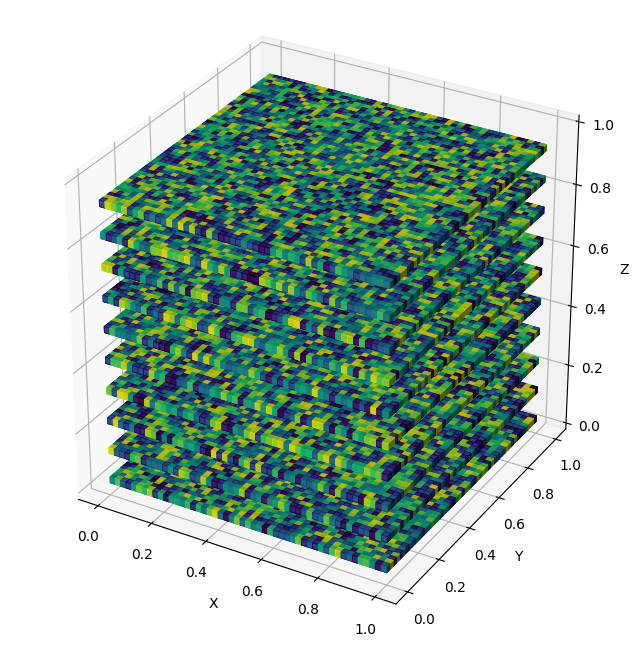

In [163]:
import matplotlib.pyplot as plt
import numpy as np
## Adapted from http://matplotlib.org/stable/gallery/mplot3d/voxels_rgb.html

# Example: mat_vals of shape (width, depth, height)
width, depth, height = 50, 50, 50
mat_vals = np.random.rand(width, depth, height)  # replace with your actual data

# Create a 3D grid
x, y, z = np.indices((width+1, depth+1, height+1)) / max(width, depth, height)

# Create a block: True where the voxel exists
cube = np.ones((width, depth, height), dtype=bool)

# Add gaps between height layers
for layer in range(height):
    if layer % 5 != 1:
        cube[:, :, layer] = False  # create gaps

# Map mat_vals to colors
# We'll use a colormap to convert values to RGB
cmap = plt.cm.viridis  # choose any matplotlib colormap
norm_vals = (mat_vals - mat_vals.min()) / (mat_vals.max() - mat_vals.min())  # normalize to [0,1]

colors = np.zeros(cube.shape + (4,))  # RGBA
colors[cube] = cmap(norm_vals[cube])  # only assign colors to existing voxels

# Plot
ax = plt.figure(figsize=(10, 8)).add_subplot(projection='3d')
ax.voxels(x, y, z, cube,
          facecolors=colors,
          edgecolors=np.clip(colors[..., :3] * 2 - 0.5, 0, 1),  # brighter edges
          linewidth=0.5)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_box_aspect([width, depth, height])
plt.show()
